# Projekt 1 - Ranking scenariuszy zarządzania odpadami radioaktywnymi
## Autorzy
- Daniel Zdancewicz [145317]
- Alex Terentowicz [145419]

## Opis
Zadaniem projektu jest stworzenie rankingu różnych scenariuszy zarządzania odpadami radioaktywnymi
z wykorzystaniem odpornej regresji porządkowej. Będziemy bazować na zbiorze danych opisanym w pracy
[Nuclear waste management: an application of the multicriteria PROMETHEE methods](./paper.pdf)

Wyobraźmy sobie, że jesteśmy instytucją zajmującą się utylizacją odpadów radioaktywnych. Naszym
zadaniem jest zaproponowanie modelu utylizacji takich odpadów dla 30-letniego programu nuklearnego.
Wybrano 3 miejsca na potencjalne składowisko, 3 scenariusze czasowe oraz 3 modele finansowania. Ze
względu na to, że ostatecznie klient może się nie zgodzić na optymalną dla nas strategię, dlatego chcielibyśmy uzyskać pełne rankingi wszystkich opcji. Zespół ekspertów ocenił wszystkie możliwe scenariusze przez nas rozważane (dane znajdują się w pliku [Nuclear waste management.csv](./resources/nuclear-waste.csv))

## Informacja preferencyjna

Wybrane i oceniane pary wariantów znajdują się w pliku [preferential-information.csv](./resources/preferential-information.csv).
Grupy, do których należą autorzy to 1 i 4, które definiują preferencję.

Rozważane preferencje:
- Wydajność produkcji elektrycznej wzrośnie.
- Ostrożny inwestor, który nie chce ryzykować.


## Zadanie 1 — UTA — Ocena wariantów
### Informacja o informacji preferencyjnej.
Preferencje zostały na podstawie przynależności do grupy 1 i 4.
Te grupy definiują preferencję:
- Wydajność produkcji elektrycznej wzrośnie.
- Ostrożny inwestor, który nie chce ryzykować.

W zadaniu były dostępne 4 kryteria oceny (wszystkie są typu koszt):
- C1 — Finansowe koszty całkowite (The total financial cost)
- C2 — Koszty finansowe przez aktualnego konsumenta (The financial cost incurred by the current consumer)
- C3 — Koszty wspierane przez przyszłego konsumenta (The financial cost supported by the future consumer)
- C4 — Ryzyko kosztów finansowych (Financial risk due to overcosts)

Co zostało zinterpretowane jako minimalizacja kryterium 4 i przyzwolenie na zaniedbania kryterium 3.
Minimalizacja czwartego kryterium (C4: ryzyko kosztów finansowych) jest zgodna z preferencją ostrożnego inwestora, który nie pragnie podejmować nadmiernego ryzyka. Tymczasem zaniedbywanie trzeciego kryterium (C3: koszty wspierane przez przyszłych konsumentów) sugeruje pomijanie kosztów przyszłościowych z racji optymistycznej prognozy wzrostu wydajności w produkcji energii elektrycznej. W rezultacie modelowanie ważności kryteriów można przedstawić jako C4 >= C1 ~ C2 >= C3.

Tę hierarchię można zinterpretować następująco: pierwszym priorytetem jest minimalizacja ryzyka kosztów finansowych, aby zaspokoić potrzeby ostrożnego inwestora. Drugą preferencją są koszty całkowite, które są równoważne z trzecim priorytetem, czyli kosztami ponoszonymi przez obecnych konsumentów. W końcu najmniej ważne są koszty wspierane przez przyszłych konsumentów, ze względu na optymistyczne prognozy wzrostu wydajności w sektorze produkcji energii elektrycznej.

### Ocena wybranych par wariantów
Przedstawione niżej 5 par wariantów wchodzące do porównań zostały wybrane na podstawie informacji preferencyjnej (5,12,33) oraz predefiniowane (24,25) według indeksów autorów.

| Para | Indeks | C1   | C2   | C3   | C4   |
|:----:|:------:|------|------|------|------|
| 05-1 |   15   | 0.87 | 0.03 | 1.00 | 0.61 |
| 05-2 |   26   | 0.71 | 0.25 | 0.88 | 0.67 |
| 12-1 |   01   | 0.60 | 0.93 | 0.00 | 0.73 |
| 12-2 |   05   | 0.62 | 0.40 | 0.56 | 0.50 |
| 24-1 |   06   | 0.78 | 0.27 | 0.71 | 0.50 |
| 24-2 |   08   | 0.64 | 0.44 | 0.54 | 0.54 |
| 25-1 |   07   | 0.40 | 0.90 | 0.00 | 0.82 |
| 25-2 |   21   | 0.83 | 0.25 | 0.80 | 0.65 |
| 33-1 |   03   | 1.00 | 0.45 | 0.57 | 0.50 |
| 33-2 |   27   | 0.80 | 0.06 | 1.00 | 0.67 |

**Ocena par wariantów**:
Na podstawie przeprowadzoną analizę, najkorzystniejszymi opcją okazały się warianty 05, 08, 06, 03 z uwzględnieniem niższych kosztów finansowych w przypadku indeksu 08 w porównaniu do indeksów 06 i 03. Kolejno, preferowane są indeksy 06, a następnie 03, 15 i 21. Warianty o indeksach 27 i 26 wykazują zbliżone do siebie charakterystyki, za to na końcu rankingu umieszczono indeksy 01 oraz 07. Wyodrębnienie takiego układu hierarchii preferencyjnej opiera się głównie na dążeniu do minimalizacji ryzyka oraz ograniczenia kosztów finansowych bez silnego uwzględniania kosztów przyszłych.

**Ostateczny ranking preferencyjny**:
05 > 08 > 06 > 03 > 15 > 21 = 27 = 26 > 01 > 07

### Problem programowania matematycznego liniowego

### Opis
Do odnalezienia rankingu został zdefiniowany problem programowania matematycznego polegający na rozwiązaniu problemu regresji porządkowej.

Problem regresji porządkowej poszukuje takiej funkcji, która umożliwia na odczytanie wartości całkowitej, dla każdego z wariantów.

Sformułowanie problemu matematycznego uwzględnia trzy typy ograniczeń:
- Odtworzenie rankingu referencyjnego, poprzez przemianowanie na sumę użyteczności cząstkowych odpowiadającym wariantom.
- Monotoniczność wartości ( w przypadku naszych kosztów jest to funkcja nierosnąca).
- Normalizacja wartości do przedziału [0,1].

In [153]:
from pulp import *
from itertools import pairwise
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

def flatten(it):
  yield from (element for iterable in it for element in iterable)

def exhaust(it): return list(it)


def accessor(value: float) -> int:
  if isinstance(value, pd.Series):
    return (value * 100).astype(np.uint8)
  return int(value * 100)

In [159]:
def read_variants() -> pd.DataFrame:
  return pd.read_csv("resources/nuclear-waste.csv", index_col=0)

def variant_constraint(utilities, variants, va, vb, epsilon = None):
  (a1, a2, a3, a4) = accessor(variants.loc[va])
  (b1, b2, b3, b4) = accessor(variants.loc[vb])
  (u1, u2, u3, u4) = utilities

  if epsilon is None:
    return (u1[a1] + u2[a2] + u3[a3] + u4[a4] ==
            u1[b1] + u2[b2] + u3[b3] + u4[b4])
  return (u1[a1] + u2[a2] + u3[a3] + u4[a4] >=
          u1[b1] + u2[b2] + u3[b3] + u4[b4] + epsilon)

def find_extremes(variants):
  return [
    accessor(variants[criterion].max())
    for criterion in variants
  ], [
    accessor(variants[criterion].min())
    for criterion in variants
  ]


In [171]:
variants = read_variants()


epsilon = LpVariable(f"e", lowBound=0, cat=LpContinuous)
utilities = [[
  LpVariable(f"u{criterion}_{i:03d}", lowBound=0, upBound=1, cat=LpContinuous)
  for i in range(0, 100 + 1)
] for criterion in range(4)]

def create_ordinal_problem(variants):
  model = LpProblem("ordinal-regression", LpMaximize)

  # 05 > 08 > 06 > 03 > 15 > 21 = 27 = 26 > 01 > 07
  references = [
    (5, 8, epsilon),
    (8, 6, epsilon),
    (6, 3, epsilon),
    (3, 15, epsilon),
    (15, 21, epsilon),
    (21, 27),
    (27, 26),
    (26, 1, epsilon),
    (1, 7, epsilon)
  ]
  # Odtworzenie rankingu referencyjnego
  for reference in references:
    model.add(variant_constraint(utilities, variants, *reference))

  # Warunek normalizacji — Typ koszt
  (worsts, bests) = find_extremes(variants)
  for (i, worst) in enumerate(worsts):
    model.add(utilities[i][worst] == 0)

  model.add(
    sum(utilities[i][best] for (i, best) in enumerate(bests))
    == 1
  )

  # Warunek monotoniczności — Typ koszt
  for (criterion, values) in enumerate([
    sorted(set(accessor(variants[criterion])))
    for criterion in variants
  ]):
    for value in values:
      model.add(utilities[criterion][value] >= 0)

    for (v1, v2) in pairwise(values):
      model.add(utilities[criterion][v1] >= utilities[criterion][v2])
  return model

# Funkcja celu
model = create_ordinal_problem(variants)
model.setObjective(model.variablesDict()['e'])
model.solve()

print(f'status: {model.status}, {LpStatus[model.status]}')
print(f"Objective: {model.objective.value()}")


status: 1, Optimal
Objective: 0.11111111


### Ranking wariantów przy użyciu metody UTA

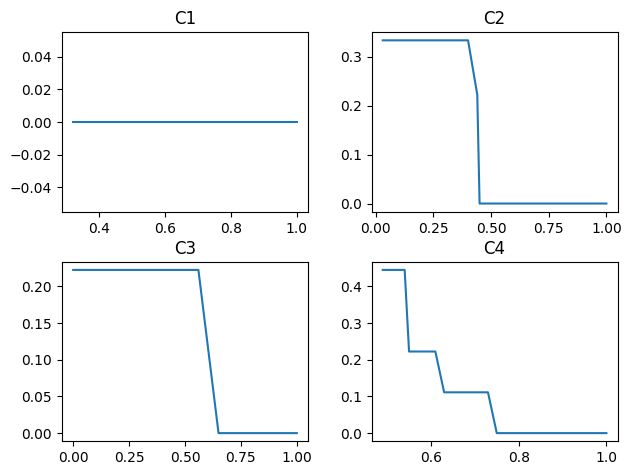

In [172]:
figure, axes = plt.subplots(2, 2)
figure.tight_layout(pad=1.5)

for (crit, criterion) in enumerate(variants):
  axis = axes[divmod(crit, 2)]
  a_values = sorted(set(accessor(variants[criterion])))
  u_values = [round(value.value(), 3) for i, value in enumerate(utilities[crit]) if i in a_values]

  axis.plot([value / 100 for value in a_values], u_values)
  axis.set_title(criterion)

plt.show()

### Ocena spójności otrzymanego rankingu z informacją preferencyjną dla kilku wybranych niereferencyjnych

In [176]:
from copy import deepcopy
ranking = pd.DataFrame(deepcopy(variants))

for (crit, criterion) in enumerate(ranking):
  ranking[f"U({criterion})"] = [0 for _ in range(len(variants))]
ranking["U"] = [0 for _ in range(len(variants))]

for (crit, criterion) in enumerate(variants):
  for variant in variants.index:
    u_arg = accessor(variants[criterion][variant])
    ranking[f"U({criterion})"][variant] += round(utilities[crit][u_arg].value(), 10)

for variant in variants.index:
  ranking["U"][variant] = np.sum(ranking.loc[variant][5:])

ranking.sort_values('U', ascending=False)

C:\Users\HououinKyouma\AppData\Local\Temp\ipykernel_16920\1354922044.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ranking[f"U({criterion})"][variant] += round(utilities[crit][u_arg].value(), 10)
C:\Users\HououinKyouma\AppData\Local\Temp\ipykernel_16920\1354922044.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ranking["U"][variant] = np.sum(ranking.loc[variant][5:])


,C1,C2,C3,C4,U(C1),U(C2),U(C3),U(C4),U
index,,,,,,,,,
5,0.62,0.40,0.56,0.50,0,0.333333,0.222222,0.444444,1.000000
8,0.64,0.44,0.54,0.54,0,0.222222,0.222222,0.444444,0.888889
6,0.78,0.27,0.71,0.50,0,0.333333,0.000000,0.444444,0.777778
12,0.74,0.25,0.80,0.49,0,0.333333,0.000000,0.444444,0.777778
11,0.61,0.54,0.38,0.49,0,0.000000,0.222222,0.444444,0.666667
3,1.00,0.45,0.57,0.50,0,0.000000,0.222222,0.444444,0.666667
2,0.66,0.55,0.45,0.49,0,0.000000,0.222222,0.444444,0.666667
9,0.65,0.30,0.71,0.55,0,0.333333,0.000000,0.222222,0.555556
15,0.87,0.03,1.00,0.61,0,0.333333,0.000000,0.222222,0.555556


Ranking preferencyjny został prawie w pełni odwzorowany. Jedyna różnica to, że wariant 26 jest przed wariantem 27. Również wyniki są w przedziale [0,1].

Najlepszą strategią okazuje się wariant 5, a najgorszą 25.
Wariant najlepszy ma wagi [0,0.3(3),0.2(2),0.4(4)].
Wariant najgorszy ma wagi [0,0,0,0].


## Zadanie 2 — UTA GMS — Analiza koniecznych relacji

## Zadanie 3 — Konstrukcja reprezentatywnej funkcji użyteczności